# Libraries 

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval as ms
from statsFuncs import compDistributions
import scipy
import random

mpl.rcParams['axes.linewidth'] = 2

# Paths 

In [47]:
fig3_path = os.getcwd()
figures_path = str(Path(fig3_path).parent)
datapath = figures_path + '/data/naive_subjects/Analysis5_27_2020/'

# Plot params

In [48]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject params 

In [49]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

99 files, 17 folders
16 subjects


In [50]:
subject_names = ['AR', 'CK', 'CT', 'EW', 'HL', 'IS', 'JP', 'MF', 'NC', 'SK', 'SS']


# Load data 

In [51]:
alldata = pd.DataFrame(columns=['SUBJECT', 'trialNumber', 'shifted_stimulusID', 'shifted_morphID', 'Error', 'responseError'])
# alldata_trimed = pd.DataFrame(columns=['SUBJECT', 'AVG_RESPONSE_ERROR'])

row = 0
for subject in subject_names:
    subjectdata_temp = pd.DataFrame()
    print(subject)
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata_temp = subjectdata[['trialNumber', 'shifted_stimulusID', 'shifted_morphID', 'Error', 'responseError']]
    subjectdata_temp = subjectdata_temp[(subjectdata_temp['trialNumber'] >= 1) & (subjectdata_temp['trialNumber'] <= 184)]
    print(len(subjectdata_temp))
    subjectdata_temp.loc[:, 'SUBJECT'] = subject
    

    if subject == 'AR':
        alldata = subjectdata_temp
    else:
        alldata = pd.concat([alldata, subjectdata_temp])
    
    row += 1
    
alldata['responseError'] = abs(alldata['responseError'])
alldata['Error'] = abs(alldata['Error'])



AR
247
CK
246
CT
248
EW
249
HL
249
IS
248
JP
249
MF
247
NC
250
SK
246
SS
249


# Polar plot

## Means per location 

In [52]:
# we have 147 locations
by_loc_by_subject = alldata.groupby(by=['SUBJECT', 'shifted_morphID'], as_index=False).mean()
by_loc_by_subject

,SUBJECT,shifted_morphID,trialNumber,shifted_stimulusID,Error,responseError
0,AR,1.0,81.000000,73.000000,7.000000,7.480475
1,AR,2.0,14.000000,132.500000,15.500000,18.761328
2,AR,3.0,20.333333,98.333333,5.333333,6.177502
3,AR,4.0,62.500000,68.500000,8.500000,8.204727
4,AR,5.0,72.000000,11.000000,6.000000,9.275987
...,...,...,...,...,...,...
1253,SS,142.0,40.000000,134.500000,7.500000,3.389286
1254,SS,143.0,46.250000,37.250000,11.250000,8.537413
1255,SS,144.0,57.666667,95.666667,9.666667,10.217828
1256,SS,146.0,58.000000,131.000000,15.000000,6.934028


## Corrected Error 

In [53]:
# alldata.dropna(inplace=True)
shifted_morph_df = pd.DataFrame(columns=['shifted_morphID', 'responseError', 'responseError_SEM'])

row=0

for morph in alldata.shifted_morphID.unique():
    
    tmp = alldata[alldata['shifted_morphID'] == morph]
    
    mean_morph, sem_morph = ms.mean_sem_returnsem(tmp['responseError'])
    
    shifted_morph_df.loc[row, 'shifted_morphID'] = morph
    shifted_morph_df.loc[row, 'responseError'] = mean_morph
    shifted_morph_df.loc[row, 'responseError_SEM'] = sem_morph
    
    row += 1
    
shifted_morph_df.sort_values(by=['shifted_morphID'], inplace=True)
shifted_morph_df.reset_index(drop=True, inplace=True)

In [54]:
theta = []
for deg in shifted_morph_df.shifted_morphID.unique():
    theta.append(np.pi / 73.5 * deg)
label_morphs = [str(i) for i in shifted_morph_df['shifted_morphID'].astype('int')]

# x = np.arange(0, len(theta), step =10)
x = np.arange(4, len(theta), step=5)
x = np.insert(x, 0, 0)
new_ticks = list()
new_label_morphs = list()

for i in x:
    new_ticks.append(theta[i])
    new_label_morphs.append(label_morphs[i])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


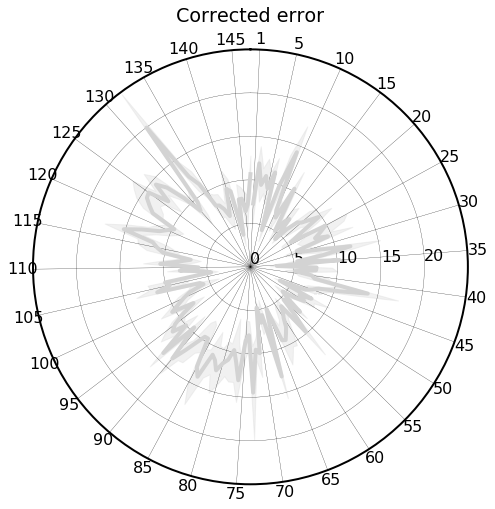

In [55]:

    # create figure
plt.figure(figsize=(8, 8))
ax = plt.axes(polar=True)
df= shifted_morph_df[['responseError']]
df_error = shifted_morph_df[['responseError_SEM']]
df_reset_index = df.reset_index(drop=True)
df.index = [theta[location] for location in df.index]
df.plot(ax=ax, lw=4, color=['lightgrey'])

ax.fill_between(np.asarray(theta), np.asarray(df_reset_index['responseError'] - df_error['responseError_SEM'], dtype='float'), 
                np.asarray(df_reset_index['responseError'] + df_error['responseError_SEM'], dtype='float'), color='lightgrey', alpha=0.3)
ax.set_theta_zero_location("N")
ax.set_xticks(new_ticks)
ax.set_xticklabels(labels=new_label_morphs)

# plt.thetagrids(np.arange(0, 360, 60), labels=new_label_morphs)
plt.grid(color='black', linewidth=0.25)
plt.ylim([0, 25])
ax.set_facecolor('white')
ax.set_theta_direction(-1)
ax.get_legend().remove()
ax.set_rlabel_position(89)
ax.set_yticks(np.arange(0, 25, step=5))
plt.title('Corrected error')
plt.savefig('CorrectedErr_naives.eps', dpi=3000)
plt.show()

## Non-corrected error 

In [56]:
# alldata.dropna(inplace=True)
shifted_morph_df = pd.DataFrame(columns=['shifted_morphID', 'Error', 'Error_SEM'])

row=0

for morph in alldata.shifted_morphID.unique():
    
    tmp = alldata[alldata['shifted_morphID'] == morph]
    
    mean_morph, sem_morph = ms.mean_sem_returnsem(tmp['Error'])
    
    shifted_morph_df.loc[row, 'shifted_morphID'] = morph
    shifted_morph_df.loc[row, 'Error'] = mean_morph
    shifted_morph_df.loc[row, 'Error_SEM'] = sem_morph
    
    row += 1
    
shifted_morph_df.sort_values(by=['shifted_morphID'], inplace=True)
shifted_morph_df.reset_index(drop=True, inplace=True)

In [57]:
theta = []
for deg in shifted_morph_df.shifted_morphID.unique():
    theta.append(np.pi / 73.5 * deg)
label_morphs = [str(i) for i in shifted_morph_df['shifted_morphID'].astype('int')]

# x = np.arange(0, len(theta), step =10)
x = np.arange(4, len(theta), step=5)
x = np.insert(x, 0, 0)
new_ticks = list()
new_label_morphs = list()

for i in x:
    new_ticks.append(theta[i])
    new_label_morphs.append(label_morphs[i])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


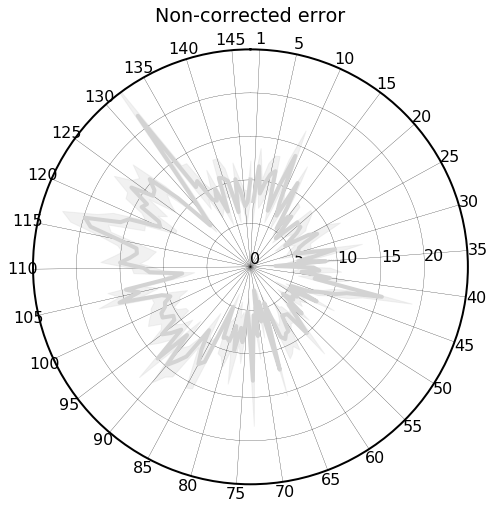

In [58]:

    # create figure
plt.figure(figsize=(8, 8))
ax = plt.axes(polar=True)
df= shifted_morph_df[['Error']]
df_error = shifted_morph_df[['Error_SEM']]
df_reset_index = df.reset_index(drop=True)
df.index = [theta[location] for location in df.index]
df.plot(ax=ax, lw=4, color=['lightgrey'])

ax.fill_between(np.asarray(theta), np.asarray(df_reset_index['Error'] - df_error['Error_SEM'], dtype='float'), 
                np.asarray(df_reset_index['Error'] + df_error['Error_SEM'], dtype='float'), color='lightgrey', alpha=0.3)
ax.set_theta_zero_location("N")
ax.set_xticks(new_ticks)
ax.set_xticklabels(labels=new_label_morphs)

# plt.thetagrids(np.arange(0, 360, 60), labels=new_label_morphs)
plt.grid(color='black', linewidth=0.25)
plt.ylim([0, 25])
ax.set_facecolor('white')
ax.set_theta_direction(-1)
ax.get_legend().remove()
ax.set_rlabel_position(89)
ax.set_yticks(np.arange(0, 25, step=5))
plt.title('Non-corrected error')
plt.savefig('NonCorrectedErr_naives.eps', dpi=3000)

plt.show()

In [59]:
shifted_morph_df

,shifted_morphID,Error,Error_SEM
0,1,7.55556,2.30972
1,2,11.6,2.09444
2,3,8.5,1.65413
3,4,9.78947,2.28724
4,5,10.8824,2.20107
...,...,...,...
142,143,10.2222,1.93278
143,144,8.69231,1.54399
144,145,7,1.95274
145,146,7.48276,1.2727


In [60]:
col = by_loc_by_subject.loc[: , "Error":"responseError"]
by_loc_by_subject['mean_errors'] = col.mean(axis=1)

In [61]:
sum(by_loc_by_subject['Error'] < by_loc_by_subject['responseError'])/len(by_loc_by_subject)

0.4538950715421304

In [62]:
by_loc_by_subject

,SUBJECT,shifted_morphID,trialNumber,shifted_stimulusID,Error,responseError,mean_errors
0,AR,1.0,81.000000,73.000000,7.000000,7.480475,7.240238
1,AR,2.0,14.000000,132.500000,15.500000,18.761328,17.130664
2,AR,3.0,20.333333,98.333333,5.333333,6.177502,5.755417
3,AR,4.0,62.500000,68.500000,8.500000,8.204727,8.352364
4,AR,5.0,72.000000,11.000000,6.000000,9.275987,7.637994
...,...,...,...,...,...,...,...
1253,SS,142.0,40.000000,134.500000,7.500000,3.389286,5.444643
1254,SS,143.0,46.250000,37.250000,11.250000,8.537413,9.893707
1255,SS,144.0,57.666667,95.666667,9.666667,10.217828,9.942247
1256,SS,146.0,58.000000,131.000000,15.000000,6.934028,10.967014
